In [11]:
import gmsh
import numpy as np
import pyvista
import ufl
from dolfinx import default_scalar_type, fem, plot
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import gmshio
from mpi4py import MPI

In [2]:
gmsh.initialize()
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000148427s, CPU 0.000133s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0485063s, CPU 0.05213s)
Info    : 1550 nodes 3099 elements


In [3]:
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(
    gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim
)

In [13]:
V = fem.functionspace(domain, ("Lagrange", 2))
x = ufl.SpatialCoordinate(domain)
beta = fem.Constant(domain, default_scalar_type(12))
R0 = fem.Constant(domain, default_scalar_type(0.3))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))

In [14]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)
boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

In [15]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [16]:
Q = fem.functionspace(domain, ("Lagrange", 5))
expr = fem.Expression(p, Q.element.interpolation_points())
pressure = fem.Function(Q)
pressure.interpolate(expr)

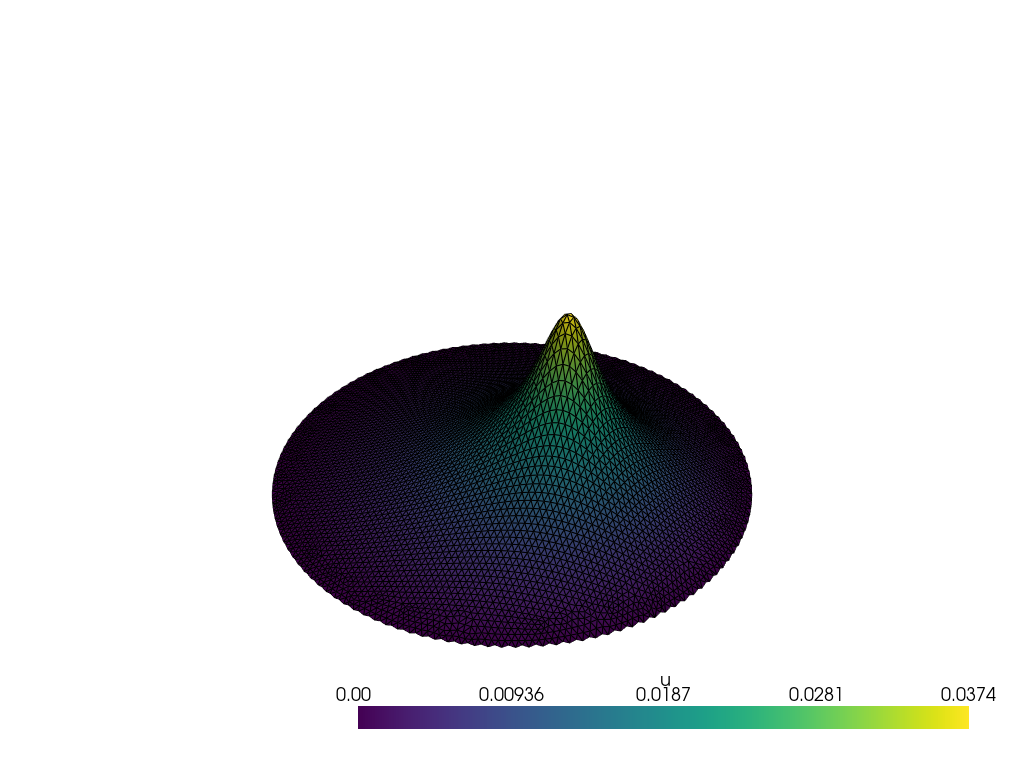

In [19]:
topology, cell_types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)
plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
plotter.show()